In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy.cluster.vq import kmeans, vq
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from skimage.restoration import denoise_nl_means, estimate_sigma

K means clustering on tiles taken from an image

(256, 256)


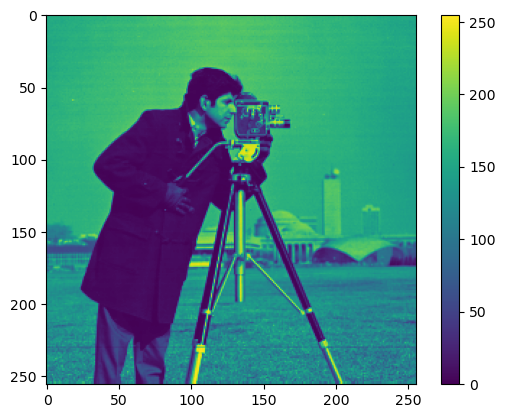

In [2]:
image_number = 3
# dimensionality (N) of subspace = 64
tile_w = 8
 

image = cv2.imread(f"Dataset/Image{image_number}.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)
mindim = np.min(image.shape)
image = image[:mindim, :mindim]

plt.imshow(image)
plt.colorbar()
plt.show();

In [3]:
def return_tiles(image, tile_width):
    """
    image: A 2D array
    tile_width: the width of a square tile
    """
    width, height = image.shape

    # Calculate the number of tiles in each dimension
    num_tiles_x = width // tile_width
    num_tiles_y = height // tile_width

    # Initialize an empty array to store tiles
    # Reshape the image into tiles
    tiles = image[:num_tiles_y * tile_width, :num_tiles_x * tile_width].reshape(
        num_tiles_y, tile_width, num_tiles_x, tile_width)

    # Transpose the axes to get the desired shape
    tiles2d = tiles.transpose(0, 2, 1, 3).reshape(num_tiles_y, num_tiles_x, tile_width, tile_width)
    tiles1d = tiles2d.reshape(num_tiles_y*num_tiles_x, tile_width*tile_width)

    return tiles2d, tiles1d

In [4]:
# The data vector
im_tiles2d, im_tiles1d = return_tiles(image, tile_w)
print(im_tiles2d.shape)
print(im_tiles1d.shape)

(32, 32, 8, 8)
(1024, 64)


In [27]:
def visualize_tiles(tiles_array):
    num_tiles_y, num_tiles_x, tile_width, _ = tiles_array.shape

    #subplot with a grid of tiles
    fig, axes = plt.subplots(num_tiles_y, num_tiles_x, figsize=(10, 10))

    # Iterate through each tile and display
    for i in range(num_tiles_y):
        for j in range(num_tiles_x):
            axes[i, j].imshow(tiles_array[i, j, :, :], vmin=0, vmax=255, cmap='viridis')
            axes[i, j].axis('off')  # Turn off axis labels

    plt.show()

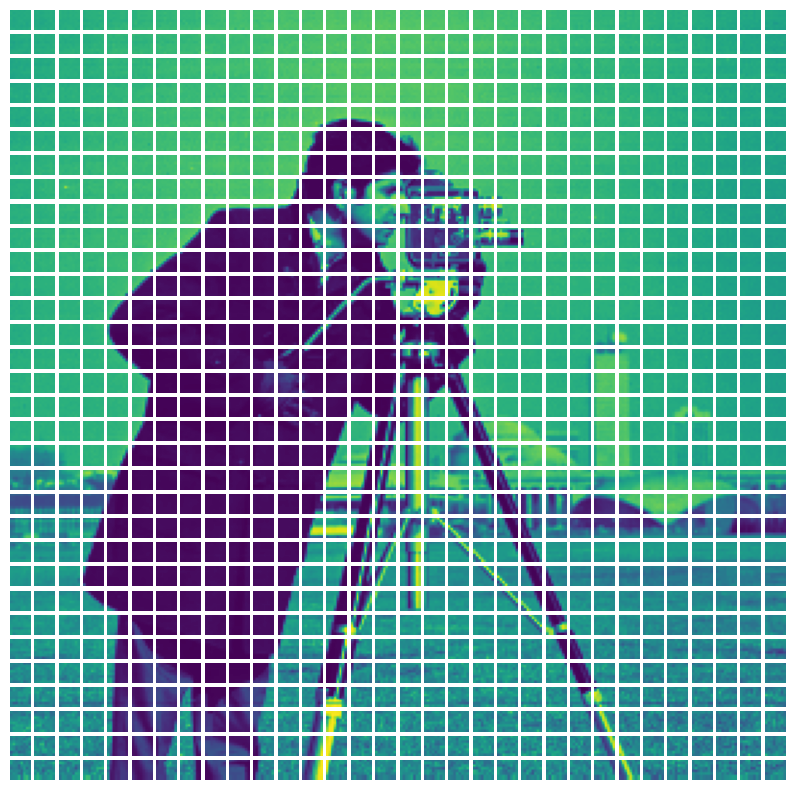

In [28]:
visualize_tiles(im_tiles2d)

In [7]:
im_tiles1d = im_tiles1d.astype(float)

### Decide the number of clusters
* And if needed, change the num_clusters argument in the start 

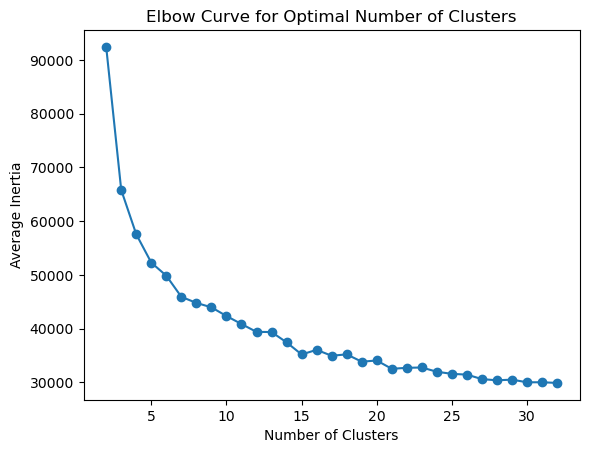

[92405.85879727956,
 65791.49707602269,
 57543.50933139105,
 52272.17698904627,
 49840.211312161795,
 45913.716145162485,
 44781.247837832925,
 43959.49942998536,
 42343.11846548417,
 40852.53787199379,
 39389.082528690495,
 39363.05902846125,
 37444.83601473431,
 35192.79838782947,
 36044.64822548887,
 34951.55334548508,
 35207.83186148827,
 33846.782147625214,
 34066.181002867954,
 32518.155613543648,
 32707.071364349613,
 32763.791535607437,
 31970.633621400837,
 31583.180353922704,
 31438.211873929587,
 30602.8692636505,
 30381.78322195806,
 30503.607509334153,
 30010.769642889267,
 30016.48436849674,
 29894.380653525186]

In [8]:
def calculate_inertia(data, centroids, cluster_indices):
    # Calculate within-cluster sum of squared distances
    # print(type(cluster_indices), cluster_indices.shape)
    distances = np.sum((data - centroids[cluster_indices]) ** 2)
    inertia = distances / len(data)
    return inertia

def elbow_method(data, max_clusters=32):
    inertias = []

    for num_clusters in range(2, max_clusters + 1):
        centroids, distortion = kmeans(data, num_clusters)
        cluster_indices, _ = vq(data, centroids)
        inertia = calculate_inertia(data, centroids, cluster_indices)
        inertias.append(inertia)

    plt.plot(range(2, max_clusters + 1), inertias, marker='o')
    plt.title('Elbow Curve for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Average Inertia')
    plt.show()

    return inertias

elbow_method(im_tiles1d, 32)

In [9]:
num_clusters = 20 

In [10]:
# Perform K-means clustering
# Adjust the number of clusters as needed
centroids, _ = kmeans(im_tiles1d, num_clusters)
print('data dimensions:', im_tiles1d.shape)
print('number of clusters:', num_clusters)
print('centroids shape:', centroids.shape)

#vector quatization
cluster_indices, _ = vq(im_tiles1d, centroids)
print('cluster_indices shape:', cluster_indices.shape)

data dimensions: (1024, 64)
number of clusters: 20
centroids shape: (20, 64)
cluster_indices shape: (1024,)


Arranging clusters, means and medoids

In [11]:
def calculate_medoid(cluster):
    """
    cluster: an mxN array of m vectors in a cluster
    """
    # Pairwise distances between points in the cluster
    distances = cdist(cluster, cluster, metric='euclidean')
    total_distances = np.sum(distances, axis=1)
    medoid_index = np.argmin(total_distances)

    # Medoid is the data point with the minimum total distance
    medoid = cluster[medoid_index]

    return medoid

def get_cluster_medoids(data, cluster_indices):
    """
    Inputs:
    data: an mxN array of m data vectors (points)
    cluster_indices: an mx1 array of m cluster indices

    Returns:
    clusters: a dictionary, indexed by cluster number and values are clustered arrays of data
    medoids: a dictionary, indexed by cluster number and values are the medoid data vector
    means: a dictionary, indexed by cluster number and values are means
    
    """
    unique_clusters = np.unique(cluster_indices)

    # Initialise a dictionary to store clusters
    clusters = {cluster: [] for cluster in unique_clusters}

    # Populate clusters dictionary with data points
    for i, cluster_index in enumerate(cluster_indices):
        clusters[cluster_index].append(data[i])

    # Calculate medoid for each cluster
    medoids = {cluster: calculate_medoid(np.array(points)) for cluster, points in clusters.items()}
    means = {cluster: np.mean(np.array(points), axis=0) for cluster, points in clusters.items()}

    return clusters, medoids, means

Centred Clusters

In [12]:
clustered_data, cluster_medoids, cluster_means = get_cluster_medoids(im_tiles1d, cluster_indices)
print ('keys of clustered_data:' ,clustered_data.keys())
print ('clustered_data[0] has shape' ,np.array(clustered_data[0]).shape)
print('cluster_medoids[0]  has shape', cluster_medoids[0].shape)
print ('cluster_means[0] has shape' , cluster_means[0].shape)

def get_centered_clusters(clustered_data, cluster_means):
    centered_clusters = {cluster: (np.array(clustered_data[cluster])-cluster_means[cluster]) for cluster in clustered_data.keys()}
    return centered_clusters

centered_clusters = get_centered_clusters(clustered_data, cluster_means)

keys of clustered_data: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
clustered_data[0] has shape (147, 64)
cluster_medoids[0]  has shape (64,)
cluster_means[0] has shape (64,)


In [13]:
#check for mean zero--> checked
summa = 0
for i in range(num_clusters):
    summa += centered_clusters[i].sum()
print (summa)

1.2448708730516955e-11


In [14]:
def pca_for_cluster(cluster):
    """ 
    Inputs:
    cluster- mxN centered array of vectors from a single cluster

    Returns:
    cluster_pca
    """
    assert isinstance(cluster, np.ndarray)

    pca = PCA()
    cluster_pca = pca.fit_transform(cluster)
    pca_vectors = pca.components_
    # print('pca vectors shape:', pca_vectors.shape)


    #padding to make the cumsum array have data_dim(8x8=64) length
    data_dim = cluster.shape[-1] 
    padding_size = max(0, data_dim - len(pca.explained_variance_ratio_))
    expl_var_ratio_cumul = np.cumsum(np.pad(pca.explained_variance_ratio_, (0, padding_size), 'constant', constant_values=0))

    return cluster_pca, expl_var_ratio_cumul, pca_vectors

#test pca function
cluster_pca, expln_var_cum, pca_vectors = pca_for_cluster(centered_clusters[0])
print(type(cluster_pca), cluster_pca.shape)
print(pca_vectors.shape)


<class 'numpy.ndarray'> (147, 64)
(64, 64)


### Creating a different basis for each cluster

Cluster 0 dynamic_basis vectors shape: (9, 64)
Cluster compression when pruning 0.90 variance is 0.0612
--------------------
Cluster 1 dynamic_basis vectors shape: (2, 64)
Cluster compression when pruning 0.90 variance is 0.4000
--------------------
Cluster 2 dynamic_basis vectors shape: (5, 64)
Cluster compression when pruning 0.90 variance is 0.0521
--------------------
Cluster 3 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 0.2000
--------------------
Cluster 4 dynamic_basis vectors shape: (8, 64)
Cluster compression when pruning 0.90 variance is 0.3333
--------------------
Cluster 5 dynamic_basis vectors shape: (5, 64)
Cluster compression when pruning 0.90 variance is 0.3571
--------------------
Cluster 6 dynamic_basis vectors shape: (8, 64)
Cluster compression when pruning 0.90 variance is 0.4000
--------------------
Cluster 7 dynamic_basis vectors shape: (3, 64)
Cluster compression when pruning 0.90 variance is 0.3333
--------------------


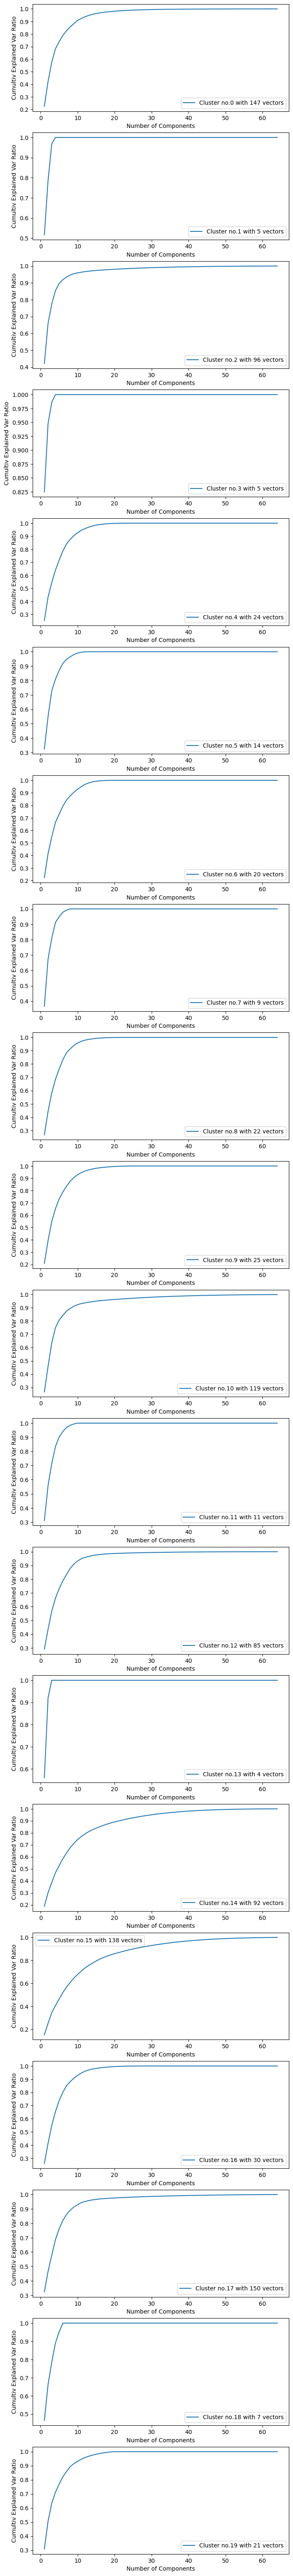

In [15]:
num_clusters = len(centered_clusters)
fig, axs = plt.subplots(nrows= num_clusters, ncols =1, figsize=(8,4* num_clusters))

#clusters_pcavectors and mean- a set basis(psi), one for each cluster
t_exp = 0.9
dynamic_psi = dict()
fixed_psi = dict()
dim_comp = 0.5
fixed_cut = int(dim_comp* np.square(tile_w))

for i, (cluster_key, points) in enumerate(centered_clusters.items()):
    cluster_pca, expln_var_cum, pca_vectors = pca_for_cluster(points)

    # find the index that reaches 0.9 cumsum variability
    # do not have the mean vector in the basis
    cutidx = np.argmax(expln_var_cum >= t_exp)
    dynamic_basis = np.array( pca_vectors[:cutidx])
    fixed_basis = np.array(pca_vectors[:fixed_cut])

    # Add the dynamic_basis vectors describing the 0.9 variance
    dynamic_psi[cluster_key] = dynamic_basis

    # Add the fixed_basis vectors which are the 50% of the the basis vectors
    fixed_psi[cluster_key] = fixed_basis

    print('Cluster %d dynamic_basis vectors shape:'%(cluster_key), dynamic_basis.shape)
    print('Cluster compression when pruning %.2f variance is %.4f'%(t_exp, dynamic_basis.shape[0]/points.shape[0]))
    print('--------------------')
                      
    axs[i].plot(range(1, len(expln_var_cum) + 1), expln_var_cum, label='Cluster no.%d with %d vectors'%(cluster_key, points.shape[0]))
    axs[i].set_xlabel('Number of Components')
    axs[i].set_ylabel('Cumultiv Explained Var Ratio')
    axs[i].legend()

# plt.savefig('results/Patching_Image_%d.pdf'%(image_number))
plt.show()

Approximate $\hat{x}$ for each data point inside the cluster

In [16]:
# Approximate x_hat = Psi_k alpha; for each tile x_hat in cluster k
def fit_to_basis(data_vectors, basis_vectors, mean_vector):
    """ 
    basis_vectors : an nxN array with a basis vector(N-dimensional) in each row 
    data_vectors : an mxN array with m examples of (N-dimensional) data.
    mean_vector : a 1xN array which is the mean vector of that cluster.
    """ 
    #remove cluster mean from all the data within the cluster
    data_vectors = data_vectors - mean_vector
    # print(data_vectors.shape)
    # print(np.mean(np.mean(data_vectors, axis=1)))
    # print(np.mean(data_vectors, axis=1))

    projection_matrix = basis_vectors.T @ (np.linalg.pinv(basis_vectors @ basis_vectors.T) @ basis_vectors)
    affine_approx = data_vectors @ projection_matrix
    # print('mean vector:',max(mean_vector))
    # print(mean_vector)
    
    approximations = affine_approx + mean_vector
    # print('In first data of the cluster, max is:',max(approximations[0]))

    errors = np.linalg.norm(data_vectors - approximations , axis=1)
    # print(errors.shape)
    return approximations, errors

cluster_key: 0
 cluster 0 has error after fitting: 
 dynamic basis selection: 60.7402 
 fixed top 0.50: 56.2349 
 ------ 
cluster_key: 1
 cluster 1 has error after fitting: 
 dynamic basis selection: 1438.9984 
 fixed top 0.50: 1433.7433 
 ------ 
cluster_key: 2
 cluster 2 has error after fitting: 
 dynamic basis selection: 1447.4292 
 fixed top 0.50: 1447.2276 
 ------ 
cluster_key: 3
 cluster 3 has error after fitting: 
 dynamic basis selection: 255.1596 
 fixed top 0.50: 247.7064 
 ------ 
cluster_key: 4
 cluster 4 has error after fitting: 
 dynamic basis selection: 620.8713 
 fixed top 0.50: 610.1765 
 ------ 
cluster_key: 5
 cluster 5 has error after fitting: 
 dynamic basis selection: 788.1518 
 fixed top 0.50: 774.6212 
 ------ 
cluster_key: 6
 cluster 6 has error after fitting: 
 dynamic basis selection: 570.0851 
 fixed top 0.50: 556.6242 
 ------ 
cluster_key: 7
 cluster 7 has error after fitting: 
 dynamic basis selection: 1189.8564 
 fixed top 0.50: 1183.3062 
 ------ 
clus

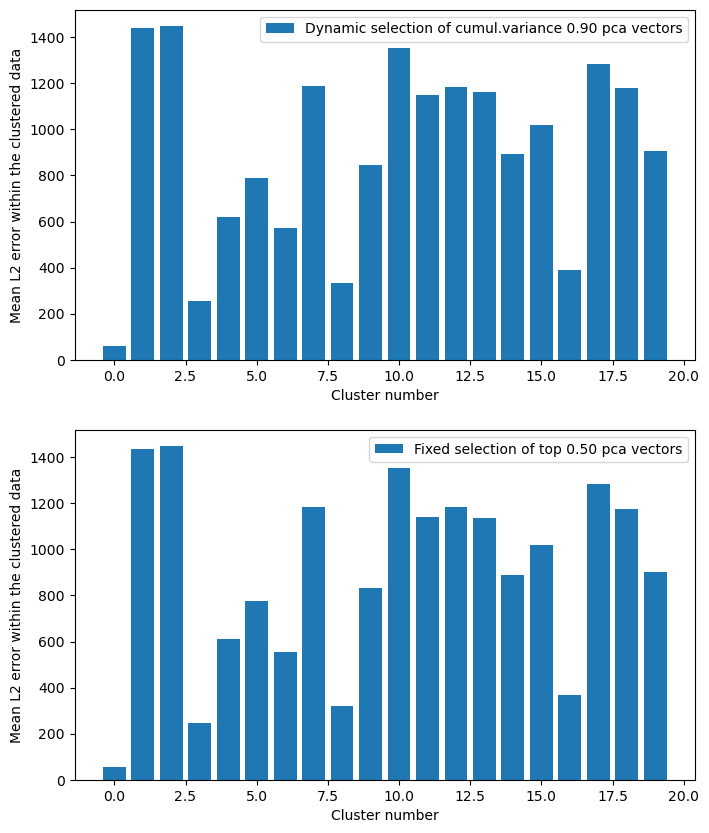

In [17]:
dyn_errors = []
fix_errors = []
for i, (cluster_key, points) in enumerate(clustered_data.items()):
    print('cluster_key:', cluster_key)
    dyn_approx, dyn_errs = fit_to_basis(clustered_data[cluster_key], dynamic_psi[cluster_key], cluster_means[cluster_key])
    fix_approx, fix_errs = fit_to_basis(clustered_data[cluster_key], fixed_psi[cluster_key], cluster_means[cluster_key])
    dyn_errors.append(np.mean(dyn_errs))
    fix_errors.append(np.mean(fix_errs))
    print(" cluster %d has error after fitting: \n dynamic basis selection: %.4f \n fixed top %.2f: %.4f \n ------ "%(i, np.mean(dyn_errs), dim_comp, np.mean(fix_errs)))

# print(np.array(dyn_errors).shape)

fig, axs = plt.subplots(nrows= 2, ncols =1, figsize=(8,10))
axs[0].bar(np.array(range(num_clusters)), dyn_errors, label='Dynamic selection of cumul.variance %.2f pca vectors'%(t_exp))
axs[0].set_xlabel('Cluster number')
axs[0].set_ylabel('Mean L2 error within the clustered data')
axs[0].legend()

axs[1].bar(range(num_clusters), fix_errors, label='Fixed selection of top %.2f pca vectors'%(dim_comp))
axs[1].set_xlabel('Cluster number')
axs[1].set_ylabel('Mean L2 error within the clustered data')
axs[1].legend()

### Approximate $\hat{x}$ for each $x$ datapoint in the original tiles1d so that I can recreate the image.

In [18]:
print('1D data array shape:',im_tiles1d.shape)
print('cluster indices shape',cluster_indices.shape)


1D data array shape: (1024, 64)
cluster indices shape (1024,)


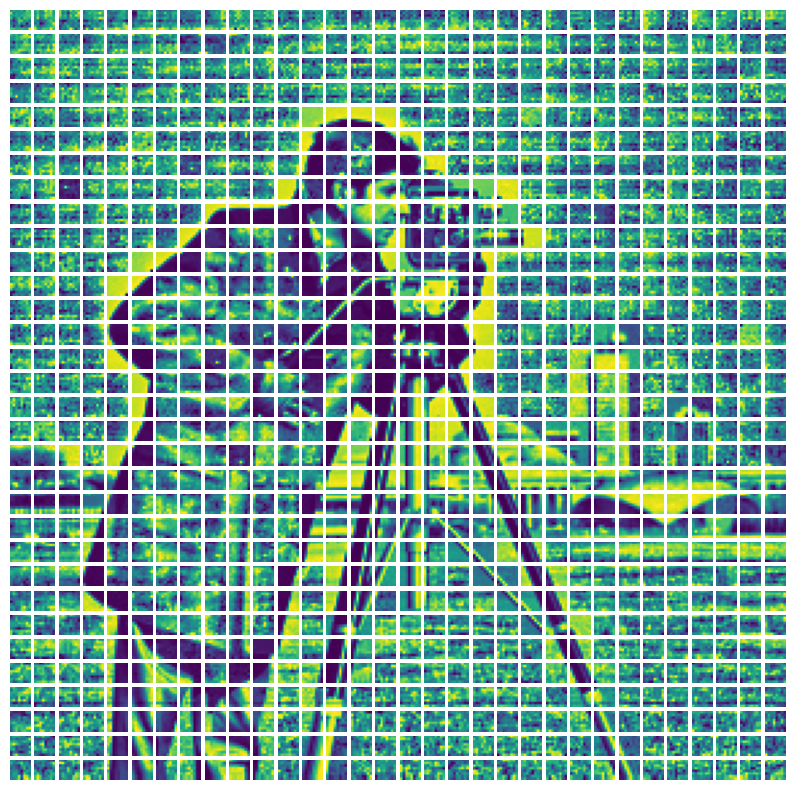

In [19]:
def visualise_approx(im_tiles1d, cluster_indices):
    approx_data1d = np.zeros_like(im_tiles1d)
    error_data = np.zeros_like(im_tiles1d)
    for i in range(len(cluster_indices)):
        fix_approx, fix_errs = fit_to_basis(im_tiles1d[i][np.newaxis,:],fixed_psi[cluster_indices[i]], cluster_means[cluster_indices[i]])
        approx_data1d[i] = fix_approx
        error_data[i] = fix_errs

    num_tiles_x = int(np.sqrt(approx_data1d.shape[0]))
    num_tiles_y = int(np.sqrt(approx_data1d.shape[0]))
    tile_width = tile_w
    tile_height = tile_w
    approx_data2d = approx_data1d.reshape(num_tiles_x, num_tiles_x, tile_width, tile_height)
    approx_image = approx_data2d.transpose(0, 2, 1, 3).reshape(num_tiles_y*tile_height, num_tiles_x*tile_width)

    return approx_data2d, approx_image

approx_data2d, approx_image = visualise_approx(im_tiles1d, cluster_indices)
visualize_tiles(approx_data2d)

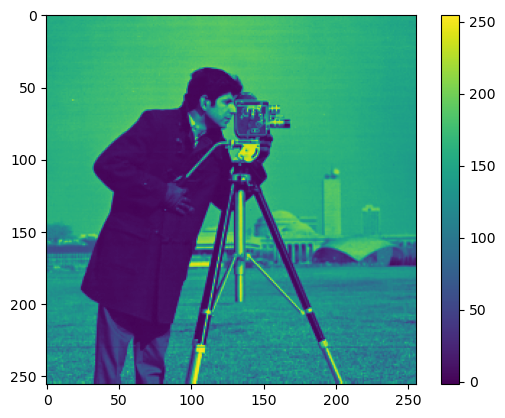

In [20]:
plt.imshow(approx_image)
plt.colorbar()
plt.show()

In [21]:
np.mean(np.square(approx_image - image))

6.727532337057225

### One function to rule them all :p

In [22]:
def clusterdenoising(image, tile_w, num_clusters, t_ratio=0.5):
    """
    Inputs: An image to be denoised, tile width, number of PCA clusters
    Outputs: A cluster approximated image using to t_ratio of PCA vectors
    """
    im_tiles2d, im_tiles1d = return_tiles(image, tile_w)
    im_tiles1d = im_tiles1d.astype(float)

    centroids, _ = kmeans(im_tiles1d, num_clusters)
    # print('data dimensions:', im_tiles1d.shape)
    # print('number of clusters:', num_clusters)
    # print('centroids shape:', centroids.shape)

    #vector quatization
    cluster_indices, _ = vq(im_tiles1d, centroids)
    # print('cluster_indices shape:', cluster_indices.shape)

    clustered_data, cluster_medoids, cluster_means = get_cluster_medoids(im_tiles1d, cluster_indices)
    # print ('keys of clustered_data:' ,clustered_data.keys())
    # print ('clustered_data[0] has shape' ,np.array(clustered_data[0]).shape)
    # print('cluster_medoids[0]  has shape', cluster_medoids[0].shape)
    # print ('cluster_means[0] has shape' , cluster_means[0].shape)

    centered_clusters = get_centered_clusters(clustered_data, cluster_means)

    t_exp = 0.9
    dynamic_psi = dict()
    fixed_psi = dict()
    dim_comp = t_ratio
    fixed_cut = int(dim_comp* np.square(tile_w))

    for i, (cluster_key, points) in enumerate(centered_clusters.items()):
        cluster_pca, expln_var_cum, pca_vectors = pca_for_cluster(points)

        # find the index that reaches 0.9 cumsum variability
        cutidx = np.argmax(expln_var_cum >= t_exp)
        dynamic_basis = np.array( pca_vectors[:cutidx])
        fixed_basis = np.array(pca_vectors[:fixed_cut])

        # Add the dynamic_basis vectors describing the 0.9 variance
        dynamic_psi[cluster_key] = dynamic_basis

        # Add the fixed_basis vectors which are the 50% of the the basis vectors
        fixed_psi[cluster_key] = fixed_basis


    approx_data2d, approx_image = visualise_approx(im_tiles1d, cluster_indices)
    return approx_data2d, approx_image

In [23]:
_ , approx_image = clusterdenoising(image,tile_w=8,num_clusters=20,t_ratio=0.5)

In [24]:
def compareNLM(image_number):
    image = cv2.imread(f"Dataset/Image{image_number}.png")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mindim = np.min(image.shape)
    image = image[:mindim, :mindim]

    # Define Gaussian noise levels
    noise_levels = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

    # Create a plot to display images
    plt.figure(figsize=(15, 8))

    #NLM args
    patch_kw = dict(patch_size=8,      # 8x8 patches
                    patch_distance=6,  # 13x13 search area
                    channel_axis=-1)

    mse_NLM = []
    mse_ours= []

    # Plot noisy images and denoised images
    for i, noise_level in enumerate(noise_levels):
        # Add Gaussian noise to the original image
        noisy_image = np.uint8(np.clip(image + np.random.normal(scale=noise_level, size=image.shape), 0, 255))
        
        # Denoise the noisy image (replace this with your denoising algorithm)
        _,ours_denoised = clusterdenoising(noisy_image,tile_w=8,num_clusters=20,t_ratio=0.5)

        #NLM Slow
        noisy_image_NLM = noisy_image[:,:, np.newaxis]
        sigma_est = np.mean(estimate_sigma(noisy_image_NLM, channel_axis=-1))
        NLM_denoised = (denoise_nl_means(noisy_image_NLM, h=0.7 * sigma_est, fast_mode=False,
                            **patch_kw) * 255).astype(np.uint8)

        mse_NLM.append(np.mean(np.square(NLM_denoised-image)))
        mse_ours.append(np.mean(np.square(ours_denoised-image)))

        # Plot the noisy image
        plt.subplot(3, 10, i + 1)
        plt.imshow(noisy_image)
        plt.title(f'Noisy (σ={noise_level})')
        plt.axis('off')

        # Plot the denoised image
        plt.subplot(3, 10, i + 11)
        plt.imshow(NLM_denoised)
        plt.title(f'AfterNLM (σ={noise_level})')
        plt.axis('off')
        
        # Plot the denoised image
        plt.subplot(3, 10, i + 21)
        plt.imshow(ours_denoised)
        plt.title(f'Ours (σ={noise_level})')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('results/Ours_meanadded_vsNLM_Image_%d_GaussianNoise.png'%(image_number))
    
    plt.figure(figsize=(10, 6))
    plt.plot(noise_levels, mse_NLM, marker='o', label='NLM')
    plt.plot(noise_levels, mse_ours, marker='o', label='Ours')
    plt.title('MSE Losses for Denoising Methods')
    plt.xlabel('Noise Level')
    plt.ylabel('MSE Loss')
    plt.xticks(noise_levels)
    plt.grid(True)
    plt.legend()
    plt.savefig('results/Ours_mean_added_vsNLM_Image_%d_GaussianNoise_MSE.png'%(image_number))
    

KeyboardInterrupt: 

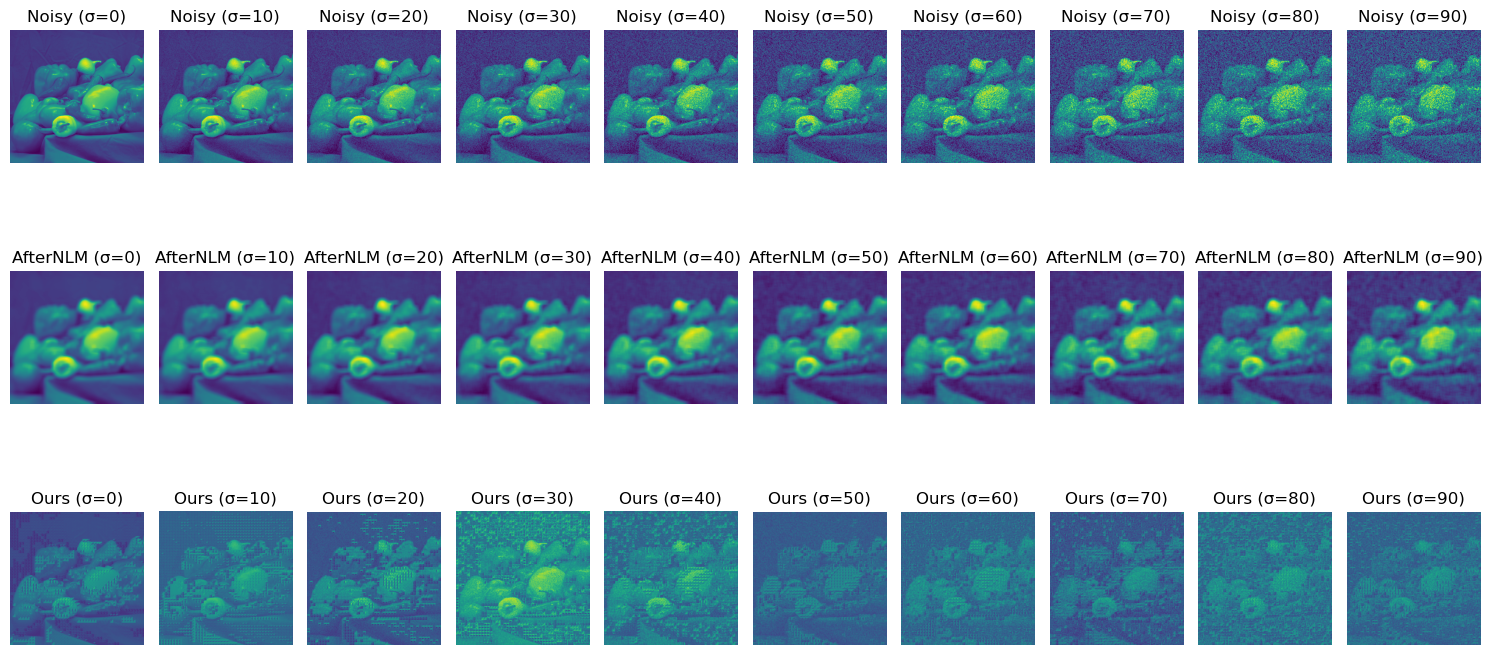

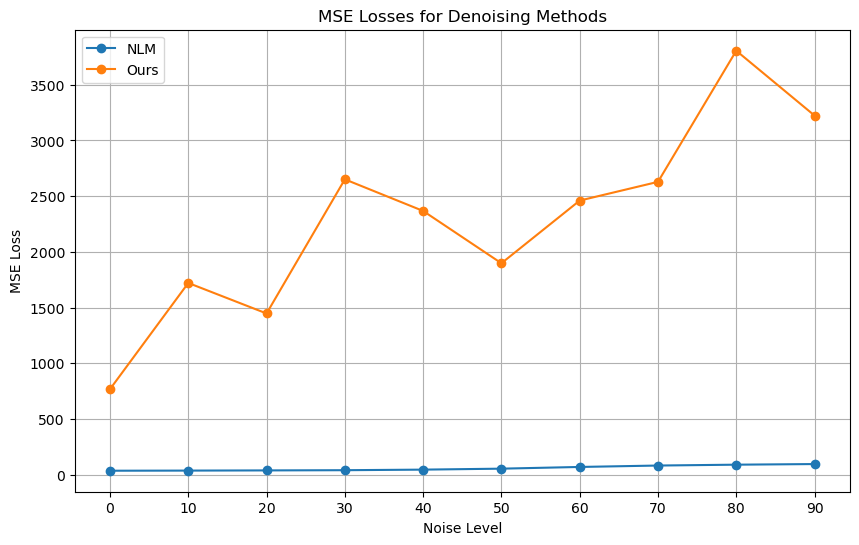

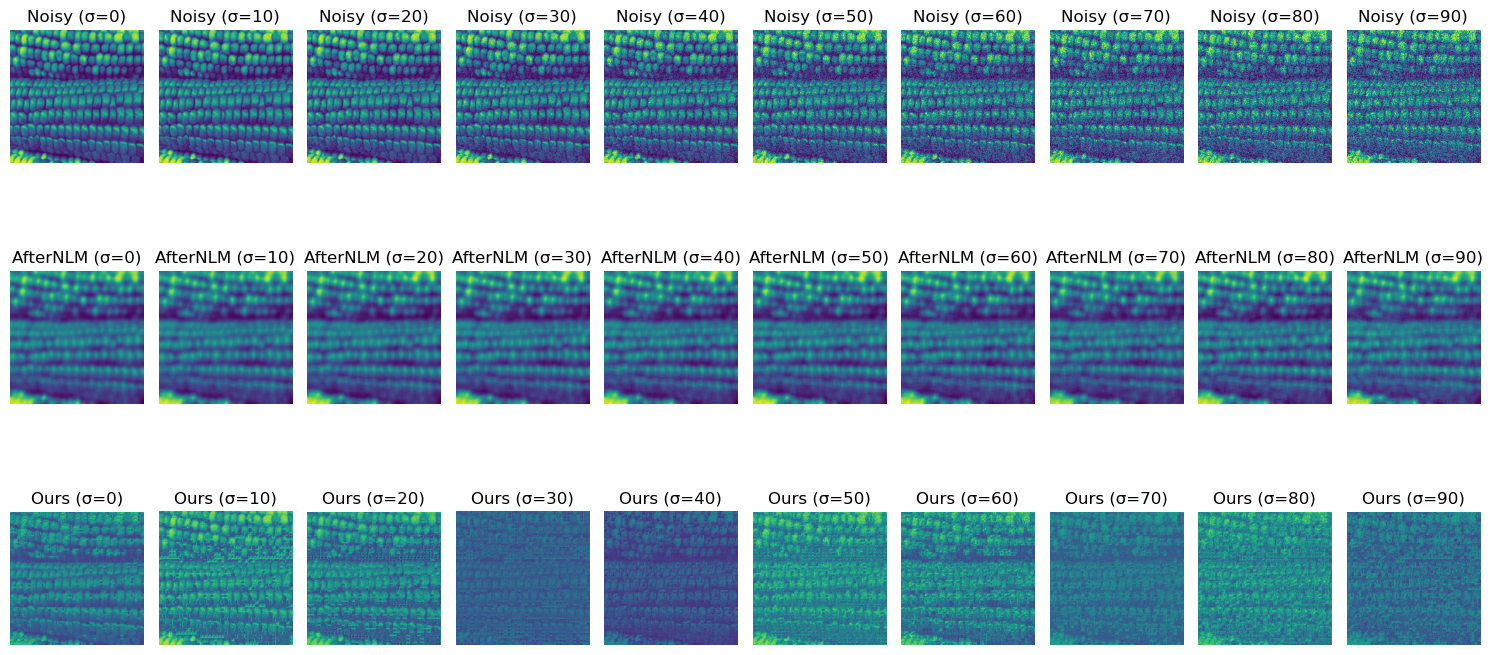

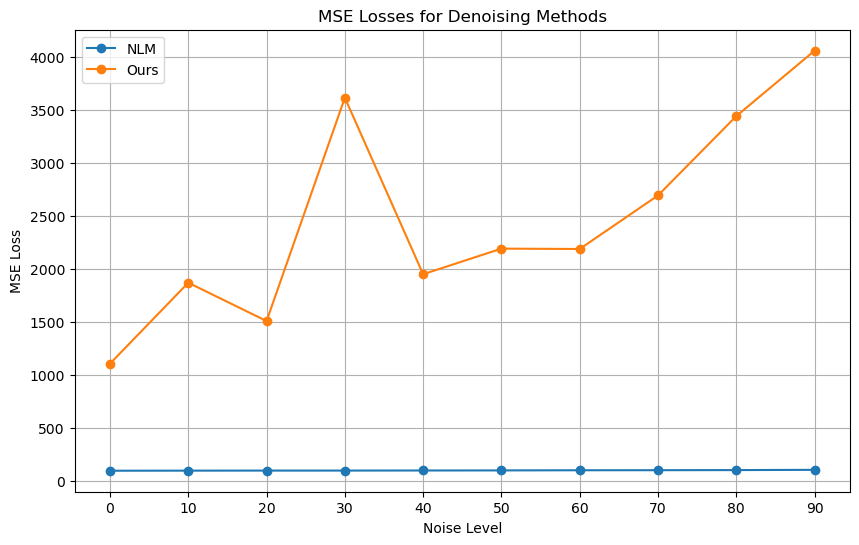

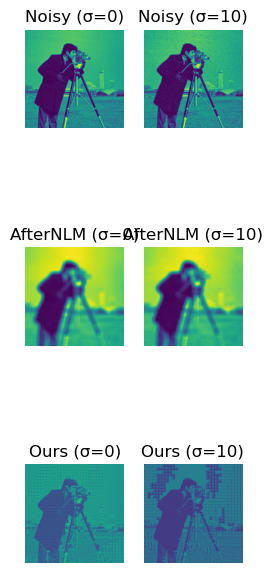

In [25]:
for image_num in range(1,4):
    compareNLM(int(image_num))

In [ ]:
#Sanity check
#NLM args
patch_kw = dict(patch_size=8,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                channel_axis=-1)
noisy_image = np.uint8(np.clip(image + np.random.normal(scale=50, size=image.shape), 0, 255))      
noisy_image_NLM = noisy_image[:,:, np.newaxis]
sigma_est = np.mean(estimate_sigma(noisy_image_NLM, channel_axis=-1))
NLM_denoised = denoise = (denoise_nl_means(noisy_image_NLM, h=1.5 * sigma_est, fast_mode=False,
                    **patch_kw) *255).astype(np.uint8)

print(np.mean(np.square(NLM_denoised-image)))

95.4799609375


: 